In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from operator import itemgetter

from sklearn.externals import joblib

pd.options.display.max_columns = 999

In [39]:
min_dedx_hits=5
min_reco_e=0.03
z_dead_start = 675
z_dead_end=z_dead_start+100

In [40]:
def track_features(row):  
    
    track_daughter_1 = 1 if row['track_daughter']==1 else 0
    track_daughter_2 = 1 if row['track_daughter']==2 else 0
    track_daughter_3 = 1 if row['track_daughter']==3 else 0
    track_is_daughter_1 = 1 if row['track_is_daughter']==1 else 0
    track_is_daughter_2 = 1 if row['track_is_daughter']==2 else 0
    
    return { 'track_daughter_1':track_daughter_1,
             'track_daughter_2':track_daughter_2,
             'track_daughter_3':track_daughter_3,
             'track_is_daughter_1':track_is_daughter_1,
             'track_is_daughter_2':track_is_daughter_2,
                     }

In [41]:
def shower_features(row):  
    
    shower_daughter_1 = 1 if row['shower_daughter']==1 else 0
    shower_daughter_2 = 1 if row['shower_daughter']==2 else 0
    shower_daughter_3 = 1 if row['shower_daughter']==3 else 0
    shower_is_daughter_1 = 1 if row['shower_is_daughter']==1 else 0
    shower_is_daughter_2 = 1 if row['shower_is_daughter']==2 else 0
    
    return { 'shower_daughter_1':shower_daughter_1,
             'shower_daughter_2':shower_daughter_2,
             'shower_daughter_3':shower_daughter_3,
             'shower_is_daughter_1':shower_is_daughter_1,
             'shower_is_daughter_2':shower_is_daughter_2,
                     }

In [42]:
vec_columns_shower  = ["shower_open_angle","shower_length","shower_pca",
                       "shower_maxangle","shower_vtxdistance","shower_daughter","shower_is_daughter",
                       "shower_fidvol_ratio","shower_spacepoint_dqdx_ratio",
                       "shower_dedx_hits_w","shower_dedx_w","shower_dedx_best_w",
                       "shower_energy_w", "shower_hitsratio_w","shower_hits_w",
                       "shower_theta","shower_energy_product","shower_start_z"
                      ]

vec_columns_track = [ "track_pca","track_start_z",
                      "predict_em","predict_mu","predict_cos","predict_pi","predict_p",  # Katrin's BDT
                      "track_res_mean","track_res_std", 
                      "track_maxangle","track_vtxdistance","track_daughter","track_is_daughter",
                      "track_spacepoint_dqdx_ratio","track_containment",
                      "track_dedx_hits_w","track_dedx_w","track_dedx_best_w",
                      "track_energy_w", "track_hitsratio_w","track_hits_w",
                      "track_theta","track_len"
                     ]
             
vec_columns_truth = [ "shower_cle", "matched_showers", "matched_showers_energy",
                      "track_cle", "matched_tracks", "matched_tracks_energy",
                      "nu_daughters_pdg","nu_daughters_E"
                    ]

flat_columns_truth = ["nu_pdg","nu_E","true_vx_sce","true_vy_sce","true_vz_sce",
                      "distance",'ccnc','qsqr','theta',"true_1eX_signal","true_nu_fiducial",
                      "lepton_E","lepton_theta",
                     ]


flat_columns_reco = ["event","subrun","run","category","vx","vy","vz","bnbweight","candidate_pdg",
                     "numu_cuts",
                     "n_showers","n_tracks","flash_time_max","flash_PE_max",
                     "chargecenter_x","chargecenter_y","chargecenter_z",
                     "total_spacepoint_containment","vtx_activity_nr"
                    ]

# Columns for the training
columns_track_XGB =       ['track_vtxdistance', 'track_maxangle',
                           'track_spacepoint_dqdx_ratio', 'predict_cos', 'track_pca',
                           'track_dedx_best_w',
                           'predict_mu', 'predict_pi',
                           'track_dedx_hits_w', 'predict_p',
                           'track_dedx_w', 'track_containment',
                           'track_hitsratio_w', 'predict_em', 
                           "track_len",
                           'track_is_daughter_1',"track_is_daughter_2", "track_daughter_1", "track_daughter_2", "track_daughter_3",
                           #'track_res_std','track_energy_w', 'track_res_mean', 'track_theta', 'track_hits_w' # <- These are the dangerous fields we prefer to avoid
                          ]


columns_shower_XGB  = ["shower_open_angle","shower_length",'vtx_activity',
                       "shower_pca", "shower_maxangle","shower_vtxdistance",
                       "shower_fidvol_ratio","shower_spacepoint_dqdx_ratio",
                       "shower_dedx_hits_w","shower_dedx_w","shower_dedx_best_w","shower_hitsratio_w",
                       'shower_is_daughter_1',"shower_is_daughter_2", "shower_daughter_1", "shower_daughter_2", #"shower_daughter_3",
                       #"shower_energy_w", ,"shower_hits_w", "shower_theta","shower_energy_product"
                      ]


columns_all_data = vec_columns_shower + vec_columns_track + flat_columns_reco
columns_all_mc = columns_all_data + flat_columns_truth + vec_columns_truth

In [43]:
sample_list = ['../Input/bnb_v11/bnb_v11_9.pckl']

#sample_list = ['../Input/bnb/bnb_9.pckl']

In [44]:
print(columns_all_data)

['shower_open_angle', 'shower_length', 'shower_pca', 'shower_maxangle', 'shower_vtxdistance', 'shower_daughter', 'shower_is_daughter', 'shower_fidvol_ratio', 'shower_spacepoint_dqdx_ratio', 'shower_dedx_hits_w', 'shower_dedx_w', 'shower_dedx_best_w', 'shower_energy_w', 'shower_hitsratio_w', 'shower_hits_w', 'shower_theta', 'shower_energy_product', 'shower_start_z', 'track_pca', 'track_start_z', 'predict_em', 'predict_mu', 'predict_cos', 'predict_pi', 'predict_p', 'track_res_mean', 'track_res_std', 'track_maxangle', 'track_vtxdistance', 'track_daughter', 'track_is_daughter', 'track_spacepoint_dqdx_ratio', 'track_containment', 'track_dedx_hits_w', 'track_dedx_w', 'track_dedx_best_w', 'track_energy_w', 'track_hitsratio_w', 'track_hits_w', 'track_theta', 'track_len', 'event', 'subrun', 'run', 'category', 'vx', 'vy', 'vz', 'bnbweight', 'candidate_pdg', 'numu_cuts', 'n_showers', 'n_tracks', 'flash_time_max', 'flash_PE_max', 'chargecenter_x', 'chargecenter_y', 'chargecenter_z', 'total_spacepo

In [45]:
model_sh_e  = joblib.load('../Input/XGBoost/model_sh_e.pkl')
model_sh_cle  = joblib.load('../Input/XGBoost/model_sh_cle.pkl')
model_sh_cle_lee  = joblib.load('../Input/XGBoost/model_sh_cle_lee.pkl')
model_sh_mu = joblib.load('../Input/XGBoost/model_sh_mu.pkl')

model_tr_e  = joblib.load('../Input/XGBoost/model_tr_e.pkl')
model_tr_cle  = joblib.load('../Input/XGBoost/model_tr_cle.pkl')
model_tr_mu = joblib.load('../Input/XGBoost/model_tr_mu.pkl')

In [46]:
def XGBoostClassification(row):
    tr_e, tr_cle, tr_mu = [],[],[]
    sh_e, sh_cle, sh_mu = [],[],[]

    if row["n_tracks"] > 0:
        tr_e ,tr_cle, tr_mu = TrackClassification(row)
        
    if row["n_showers"] > 0:
        sh_e, sh_cle, sh_cle_lee, sh_mu = ShowerClassification(row)
    
    return pd.Series({
        'track_electron_score': tr_e,
        'track_closest_electron_score': tr_cle,
        'track_muon_score': tr_mu,
        'shower_electron_score': sh_e,
        'shower_closest_electron_score': sh_cle,
        'shower_cle_lee_score': sh_cle_lee,
        'shower_muon_score': sh_mu,
    })
    
    
def TrackClassification(row):
    pred_tr_e = []
    pred_tr_mu = []
    pred_tr_cle= []
    
    XGB_input = []
    
    for tr in range(row["n_tracks"]):
        if (row['track_dedx_hits_w'][tr]>=min_dedx_hits) and (row['track_energy_w'][tr]>=min_reco_e):
            if(z_dead_start>row["track_start_z"][tr] or z_dead_end<row["track_start_z"][tr]):
                d_tr={}

                for field in vec_columns_track:
                    d_tr[field]=row[field][tr]
                d_tr = {**d_tr,**track_features(d_tr)}
                d_tr["vtx_activity"]= row["vtx_activity"]
                XGB_input.append( np.asarray(itemgetter(*columns_track_XGB)(d_tr)))
                
    if(len(XGB_input)>0):      
        XGB_input = np.array(XGB_input)
        pred_tr_e = model_tr_e.predict_proba( XGB_input )[:,1] 
        pred_tr_cle = model_tr_cle.predict_proba( XGB_input )[:,1]
        pred_tr_mu = model_tr_mu.predict_proba( XGB_input)[:,1]  
    return pred_tr_e, pred_tr_cle, pred_tr_mu
    
    
def ShowerClassification(row):
    pred_sh_e = []
    pred_sh_mu = []
    pred_sh_cle= []
    pred_sh_cle_lee =[]
    
    XGB_input = []
    
    for sh in range(row["n_showers"]):
        if (row['shower_dedx_hits_w'][sh]>=min_dedx_hits) and (row['shower_energy_w'][sh]>=min_reco_e):
            if(z_dead_start>row["shower_start_z"][sh] or z_dead_end<row["shower_start_z"][sh]):
                d_sh={}

                for field in vec_columns_shower:
                    d_sh[field]=row[field][sh]
                d_sh = {**d_sh,**shower_features(d_sh)}
                d_sh["vtx_activity"]= row["vtx_activity"]
                XGB_input.append(np.asarray(itemgetter(*columns_shower_XGB)(d_sh)))
                
    if(len(XGB_input)>0):      
        XGB_input = np.array(XGB_input)      
        pred_sh_e = model_sh_e.predict_proba( XGB_input )[:,1] 
        pred_sh_cle = model_sh_cle.predict_proba( XGB_input )[:,1]
        pred_sh_mu = model_sh_mu.predict_proba( XGB_input)[:,1]  
        pred_sh_cle_lee = model_sh_cle_lee.predict_proba( XGB_input)[:,1]  
    return pred_sh_e, pred_sh_cle, pred_sh_cle_lee, pred_sh_mu

In [47]:
columns_final_reco_vec = ['shower_electron_score','track_muon_score',
                          'shower_muon_score','track_electron_score',
                          'track_closest_electron_score','shower_closest_electron_score',"shower_cle_lee_score",
                          "track_energy_w","shower_energy_w"
                         ]

columns_final_truth_vec =['nu_daughters_pdg','nu_daughters_E'] 


columns_final_data = flat_columns_reco + columns_final_reco_vec 
columns_final_mc = columns_final_data + columns_final_truth_vec + flat_columns_truth

In [48]:
##########
data=True
##########

df_joined = pd.DataFrame()
columns_all = columns_all_mc
columns_final = columns_final_mc
if data:
    columns_all = columns_all_data
    columns_final = columns_final_data
    
for sample in sample_list:
    print("Reading in the sample (data:",data,")")
    df_sample = pd.read_pickle(sample)
    #df_sample = df_sample.head(15)
    duplicates = df_sample.duplicated(subset=["run","subrun","event"]).sum()
    print("There were duplicates in the beginning:",duplicates)

    droplist = [x for x  in df_sample.columns if (x not in columns_all)]
    df_sample.drop(droplist,inplace=True,axis=1)
    print("Entries in current sample:",len(df_sample.index))
    #print(df_sample.columns)
    df_sample["vtx_activity"] = df_sample[['n_tracks','n_showers']].sum(axis=1) > 1
    df_scores = df_sample.apply(XGBoostClassification,axis=1)
    df_sample = pd.concat([df_sample, df_scores], axis=1)    
    df_sample = df_sample[columns_final]
    df_joined = pd.concat([df_joined,df_sample],ignore_index=True,copy=False)
    print('done sample')

    
df_joined.head(10)
duplicates = df_joined.duplicated(subset=["run","subrun","event"]).sum()
print("There were duplicates in the end:",duplicates)

Reading in the sample (data: True )
There were duplicates in the beginning: 0
Entries in current sample: 11630
done sample
There were duplicates in the end: 0


In [49]:
df_joined.to_pickle('../bnb_v11_xgb.pckl')

In [50]:
print(len(df_joined.index))
print(df_joined['category'].value_counts())

11630
6    11630
Name: category, dtype: int64


In [51]:
df_pure=df_sample[df_sample.apply(lambda x: np.all(np.array(x['track_muon_score'])<0.10) and
                                            np.all(np.array(x['shower_muon_score'])<0.15) and
                                         (np.any(np.array(x['shower_electron_score'])>0.9) or np.any(np.array(x['track_electron_score'])>0.99) ),
                                  axis=1)]

In [52]:
print(len(df_pure.index))
print(df_pure['category'].value_counts())

25
6    25
Name: category, dtype: int64


,event,subrun,run,category,vx,vy,vz,bnbweight,candidate_pdg,numu_cuts,n_showers,n_tracks,flash_time_max,flash_PE_max,chargecenter_x,chargecenter_y,chargecenter_z,total_spacepoint_containment,vtx_activity_nr,shower_electron_score,track_muon_score,shower_muon_score,track_electron_score,track_closest_electron_score,shower_closest_electron_score,shower_cle_lee_score,track_energy_w,shower_energy_w
0,6927,138,5891,6,230.053146,21.788301,14.140611,1,14,15,2,1,4.531250,856.595193,238.294876,34.879959,30.894804,0.726788,3,[0.43487155],[0.97770965],[0.4754494],[0.0050366344],[0.00074404775],[0.084577665],[0.15345903],[0.16385503],"[0.058602482, 0.019656038]"
1,6999,139,5891,6,102.791824,-19.576372,127.421738,1,14,17,1,2,3.811250,1461.149052,133.291794,-24.245756,193.431107,1.000000,3,[],"[0.9006173, 0.030838156]",[],"[0.0027256864, 0.032126393]","[0.0019069079, 0.019784737]",[],[],"[0.3423044, 0.07514269]",[0.007298016]
2,7107,142,5891,6,17.243958,28.223597,516.429504,1,12,16,1,2,4.622500,2541.760980,43.961788,48.978764,519.963074,0.765905,2,[],[0.5611896],[],[0.01949071],[0.010370867],[],[],"[0.06964473, 0.025245044]",[0.06358269]
3,7388,147,5891,6,69.663673,79.544151,186.905975,1,14,16,1,1,3.526875,1436.312024,40.464012,54.904556,197.755402,0.948089,2,[],[],[],[],[],[],[],[0.20897558],[0.028197242]
4,1477,29,5208,6,216.043777,-17.870514,699.057983,1,14,12,1,2,4.202500,2773.767547,129.738174,23.563917,974.647400,0.150224,2,[],[],[],[],[],[],[],"[0.18363146, 0.0075113466]",[0.034553345]
5,1481,29,5208,6,87.835556,-45.302570,478.844208,1,14,17,1,1,3.991250,1441.919739,140.998215,5.290534,535.172668,1.000000,2,[],[],[],[],[],[],[],[0.60397977],[0.015333406]
6,1507,30,5208,6,208.906631,-12.415639,810.915100,1,12,12,3,1,4.553125,498.087652,212.511932,79.652824,774.808716,0.982272,2,[],[],[],[],[],[],[],[0.0],"[0.24213849, 0.0, 0.0038318192]"
7,1510,30,5208,6,62.467484,64.983543,242.031296,1,14,14,4,3,3.961250,428.761519,96.641640,-17.612673,297.324158,0.805902,3,[0.2607211],"[0.9527622, 0.03786894]",[0.38104612],"[0.005278837, 0.011856718]","[0.0011173014, 0.0040061413]",[0.01792327],[0.059956886],"[0.58368266, 0.20149742, 0.028069625]","[0.032979775, 0.03973078, 0.02209422, 0.0]"
8,1597,31,5208,6,194.715271,-60.062981,281.477966,1,14,16,1,2,4.381250,1353.003145,155.155106,26.522127,361.673828,0.858382,2,[0.32752842],[0.9640857],[0.26681444],[0.0027661105],[0.0013862585],[0.08789318],[0.19736448],"[0.5210645, 0.15456922]",[0.043212213]
9,1627,32,5208,6,228.404816,-61.945591,410.106873,1,14,2,1,1,3.511250,1097.444681,231.485092,-86.712349,402.357208,0.575101,2,[],[0.97850454],[],[0.0026634792],[0.0008409025],[],[],[0.07950632],[0.005371377]


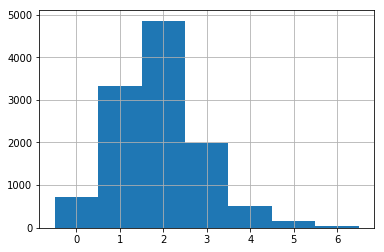

In [53]:
#Roberto's Nue
#df_joined[(df_joined["event"]==1515) & (df_joined["run"]==5328)].head()
df_joined[(df_joined["event"]==31) & (df_joined["run"]==5513)].head()
df_joined["vtx_activity_nr"].hist(bins=7,range=(-.5,6.5))
df_joined.head(15)